## Sample YOLO image inference

In [15]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [16]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
from customUtils import render
import torchvision.transforms as transforms
import keyboard
import win32api


# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5l', pretrained=True, verbose=False, )
model.to(device)
model.eval()


YOLOv5  2023-7-2 Python-3.10.9 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)

100%|██████████| 89.3M/89.3M [00:01<00:00, 73.6MB/s]

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 64, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1

In [17]:
# image = Image.open('./bus.jpg')
# # Inference
# with torch.no_grad():
#     predictions = model(image, size = 640).pred
# print(predictions)


# render(image, predictions[0], model.names)

## Sample PID for mouse control

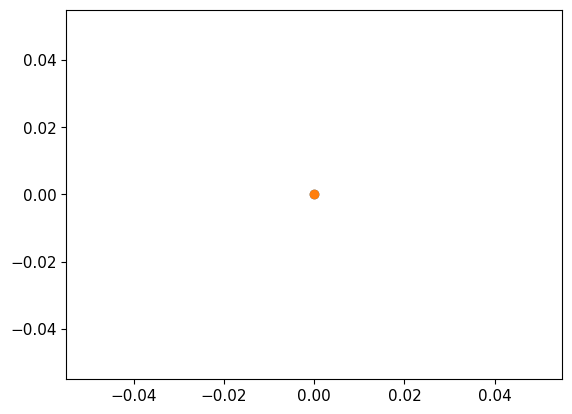

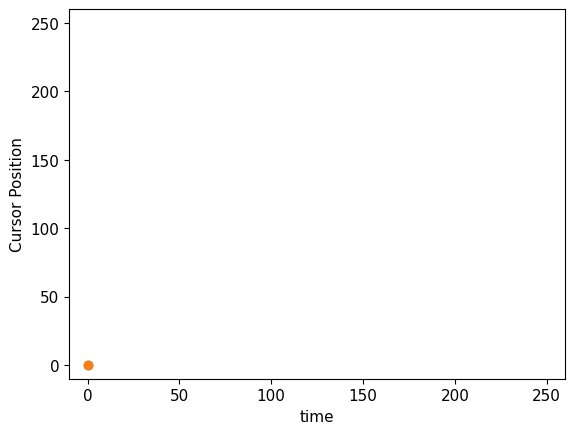

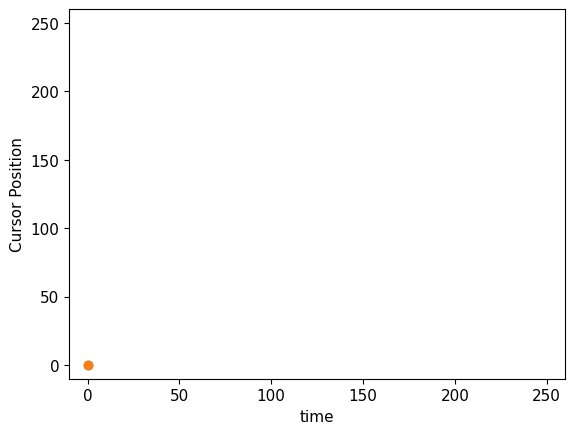

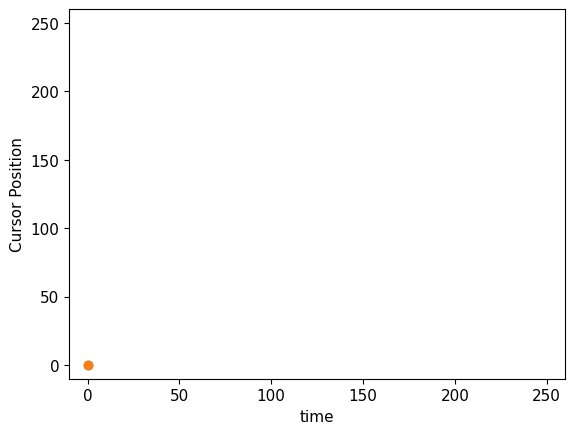

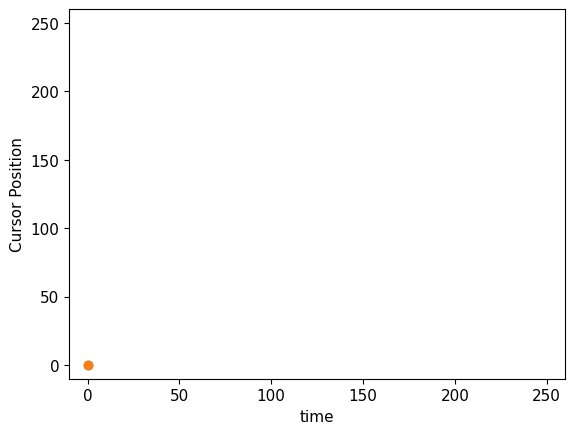

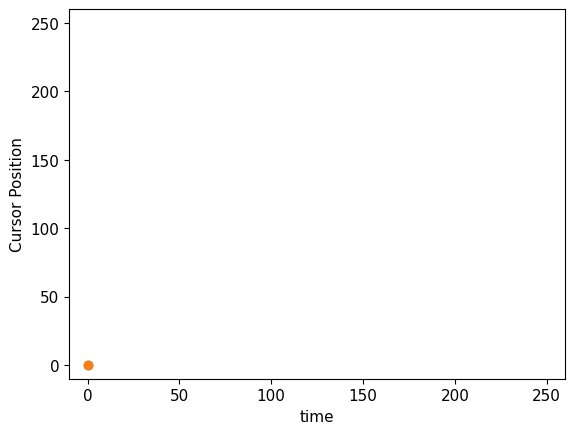

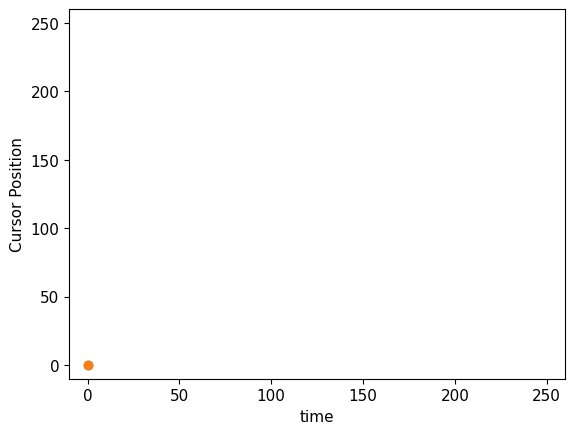

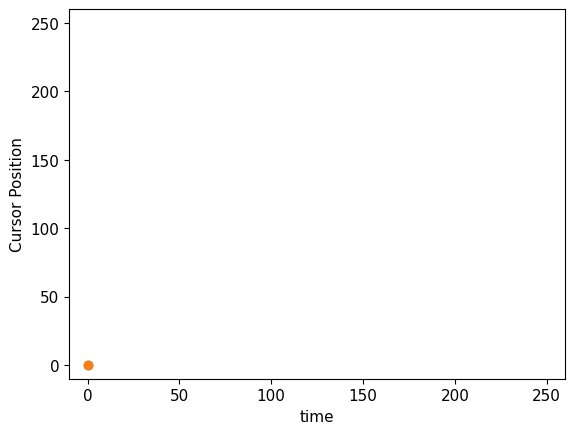

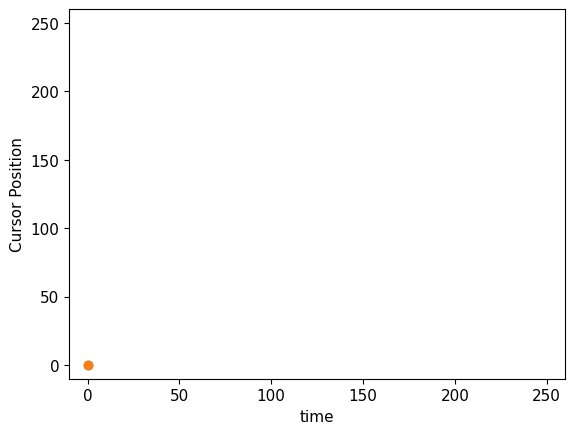

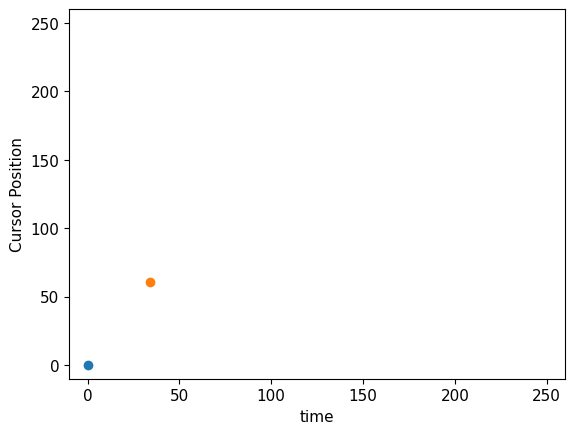

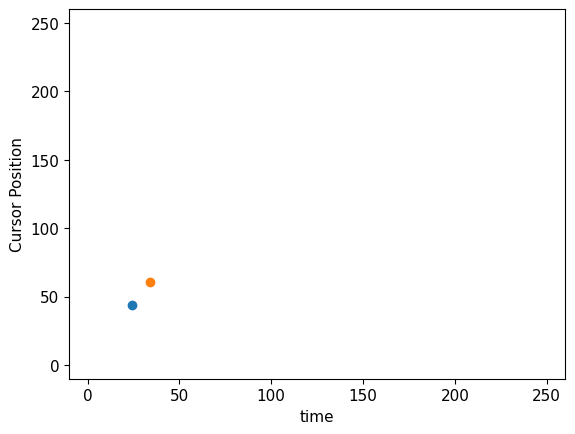

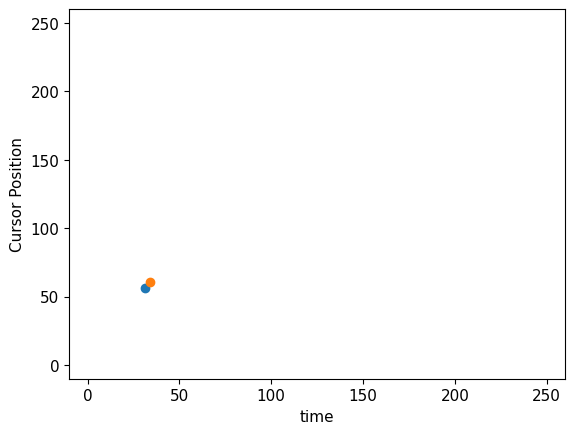

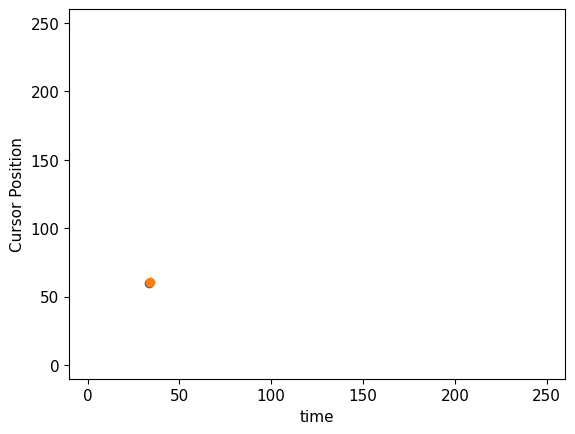

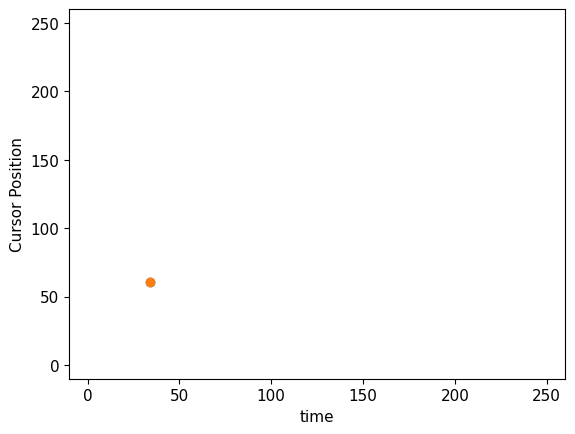

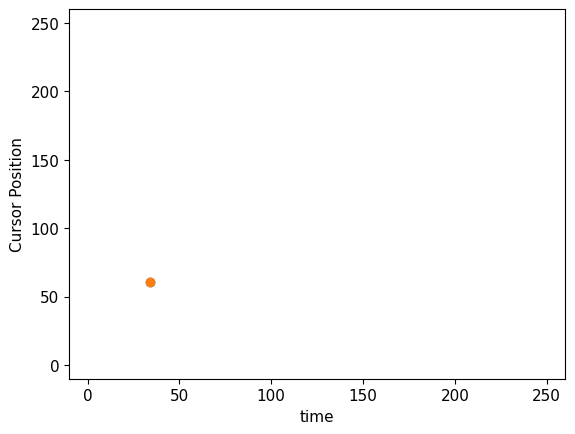

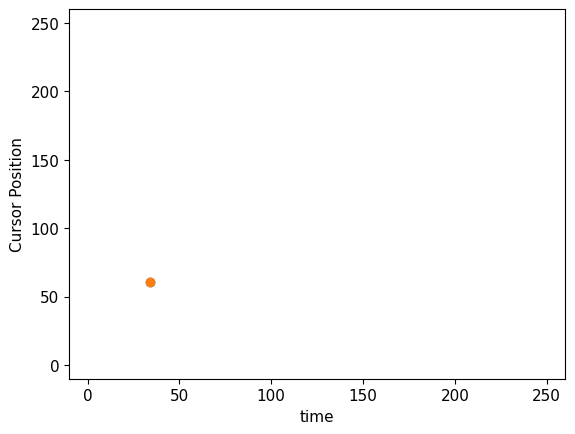

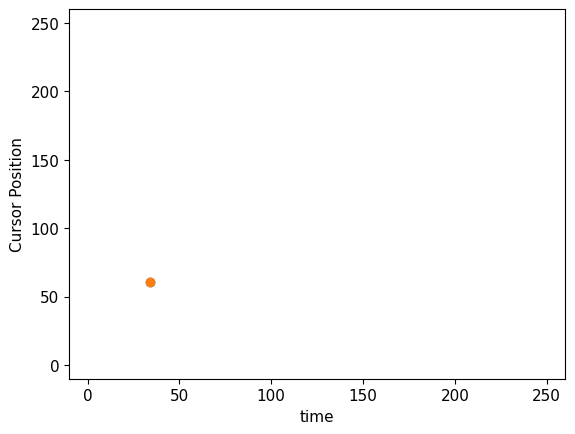

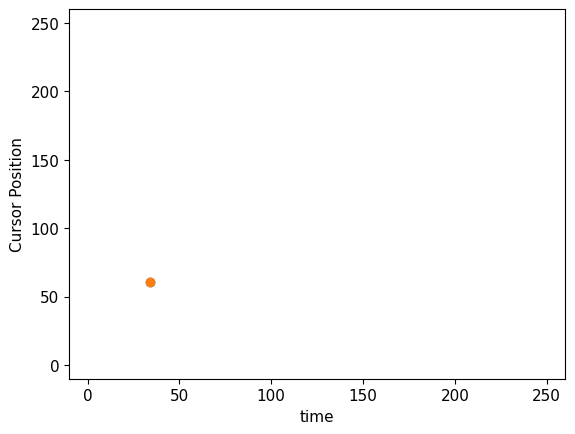

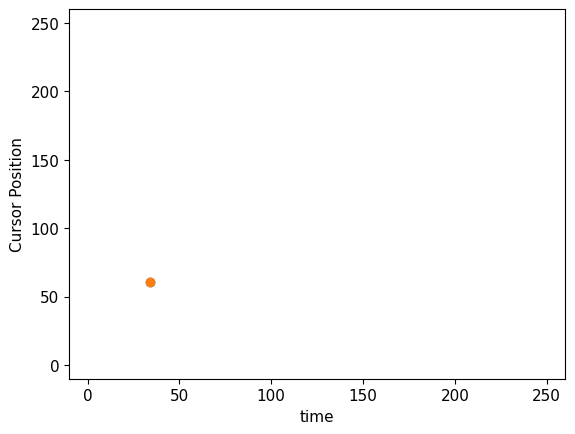

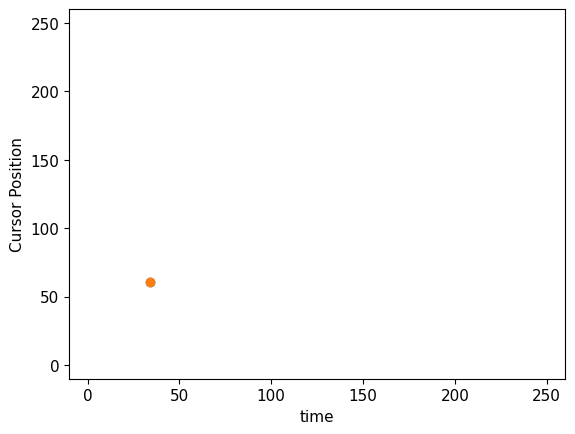

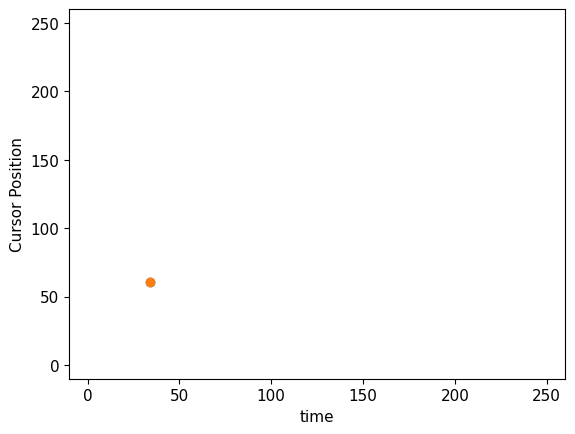

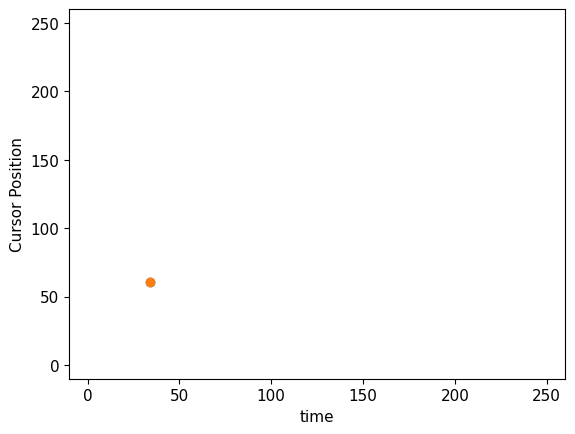

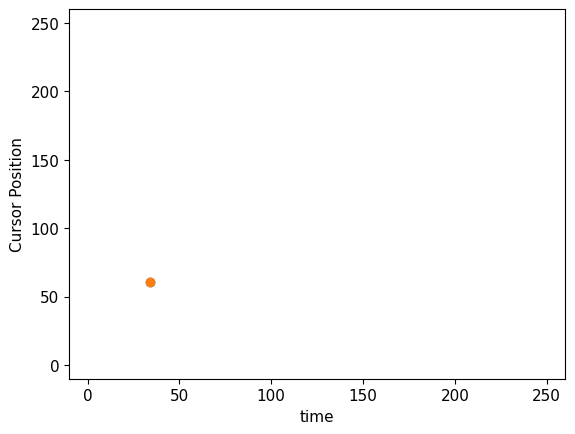

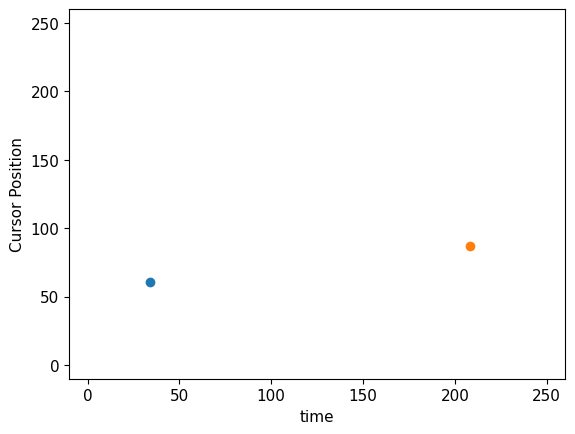

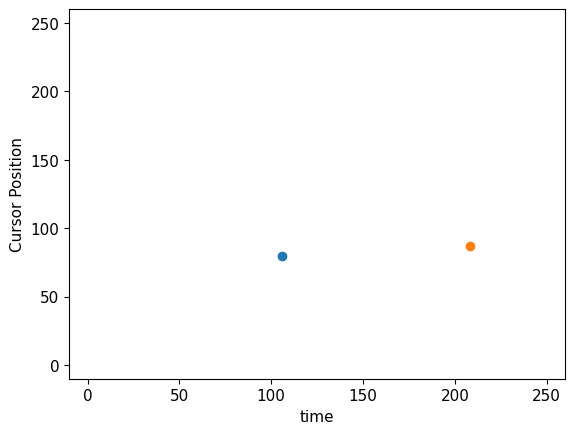

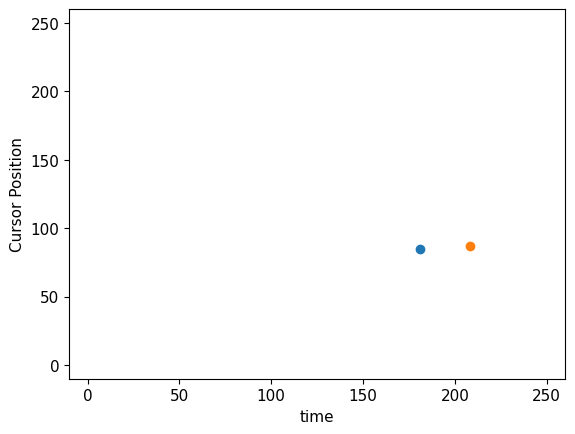

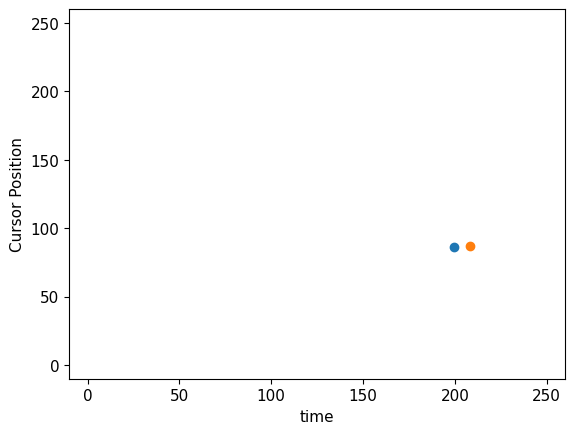

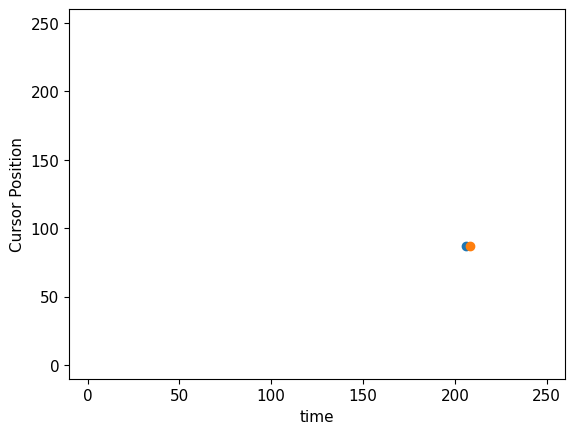

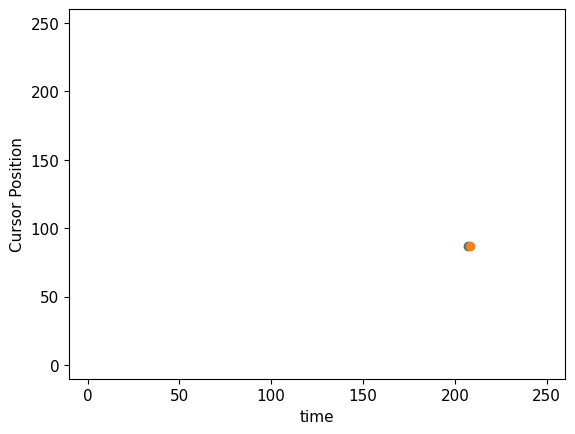

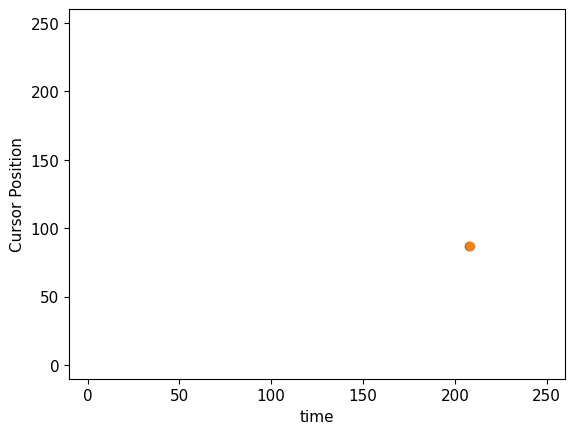

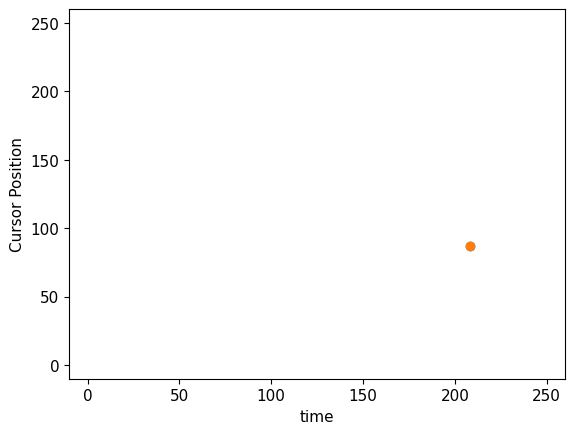

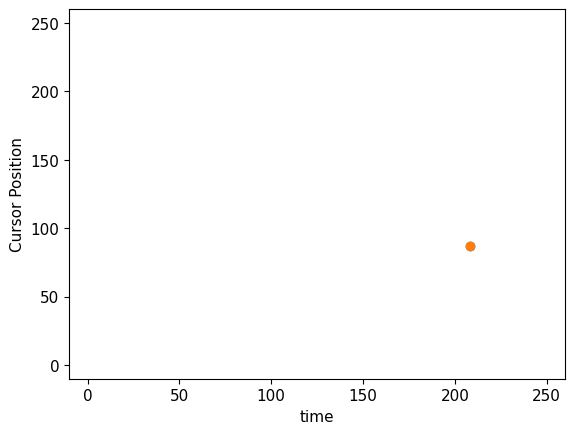

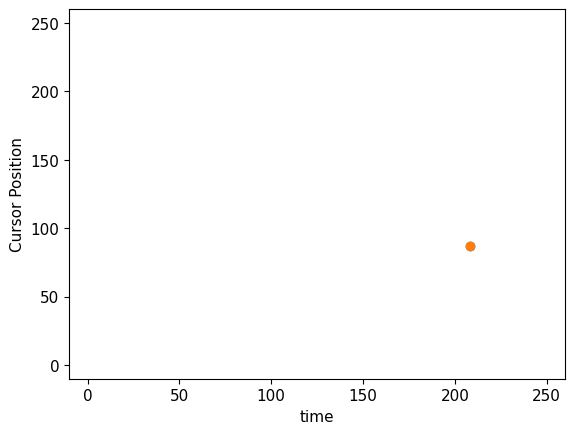

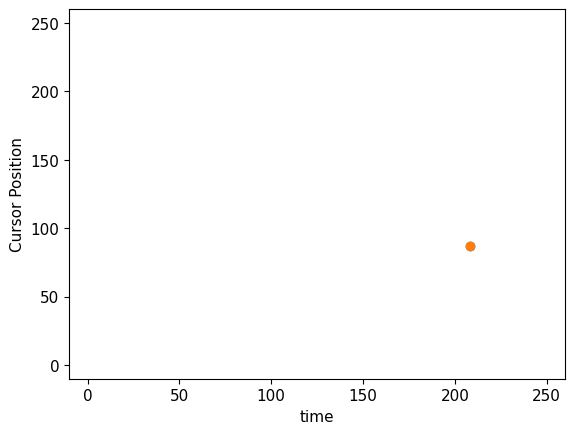

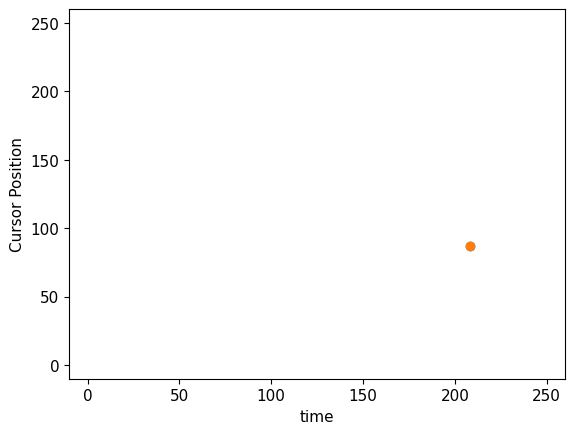

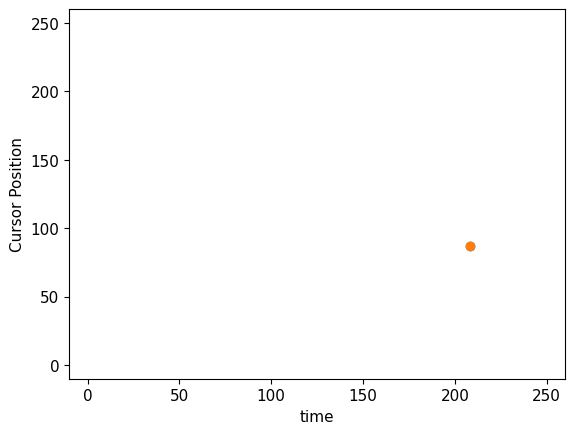

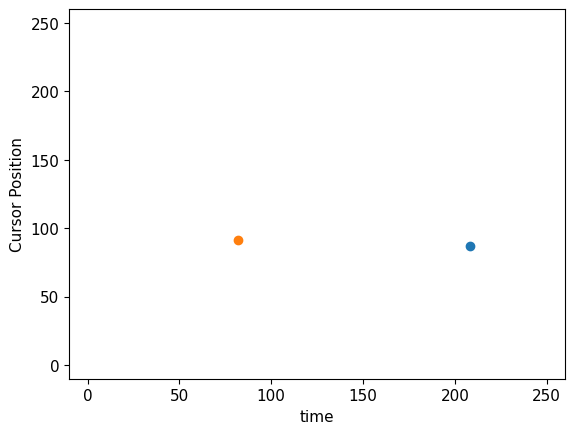

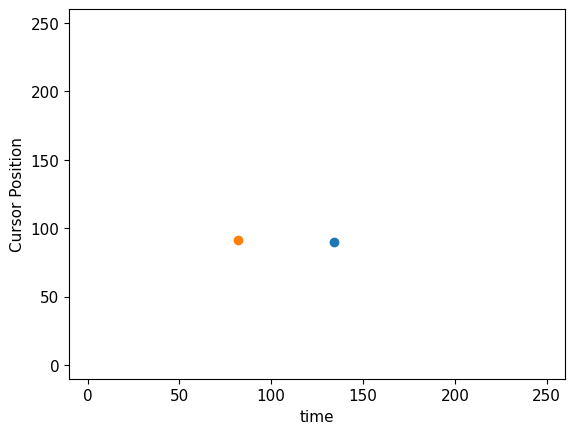

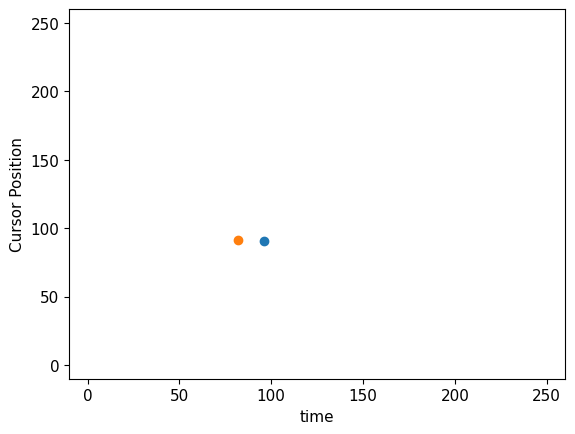

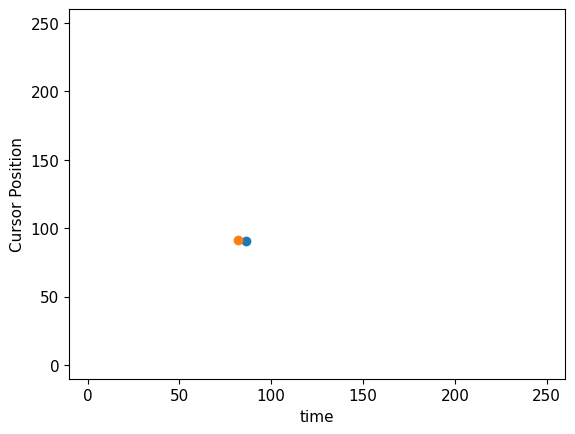

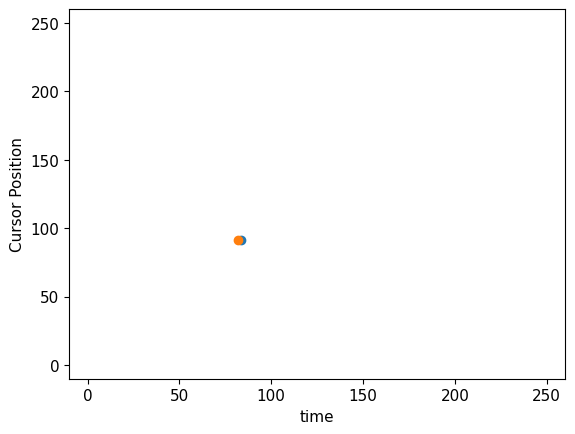

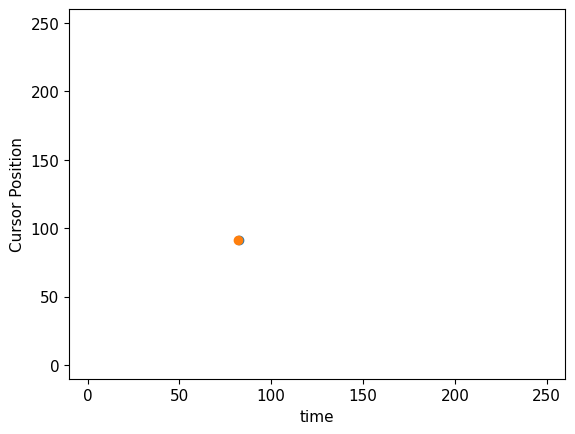

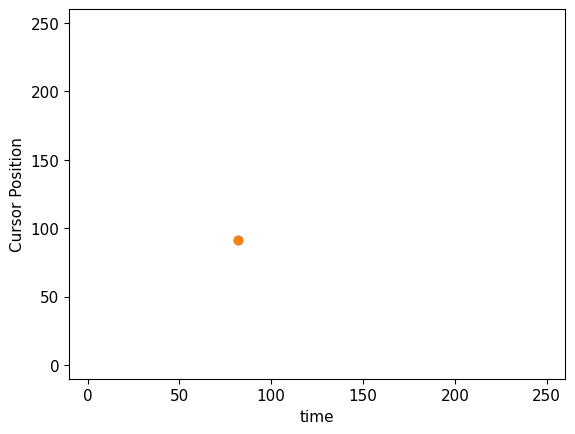

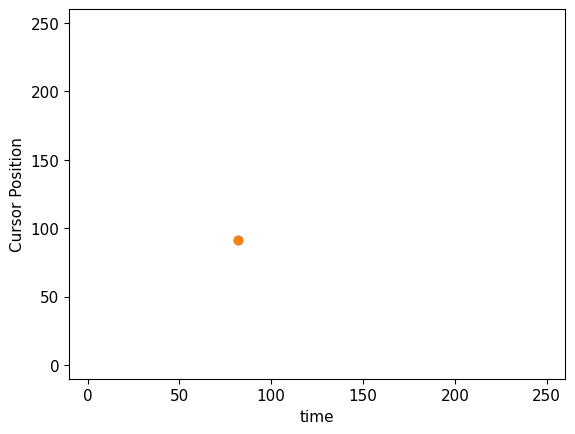

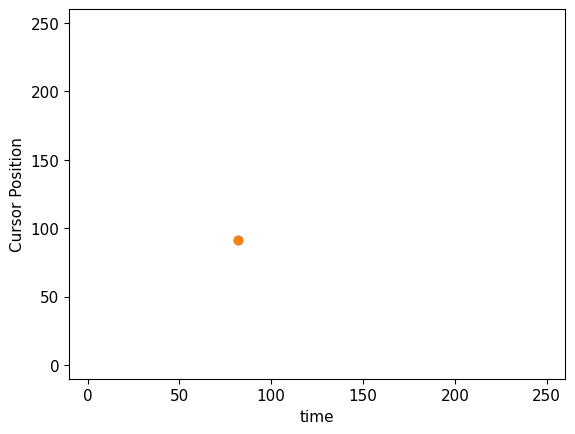

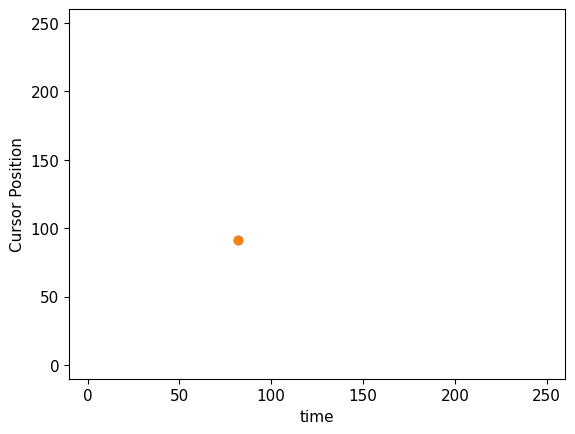

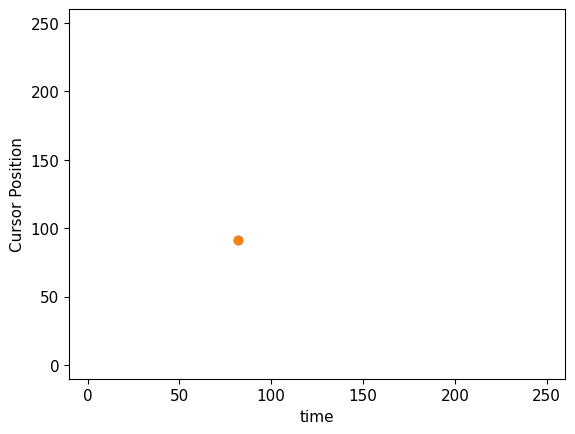

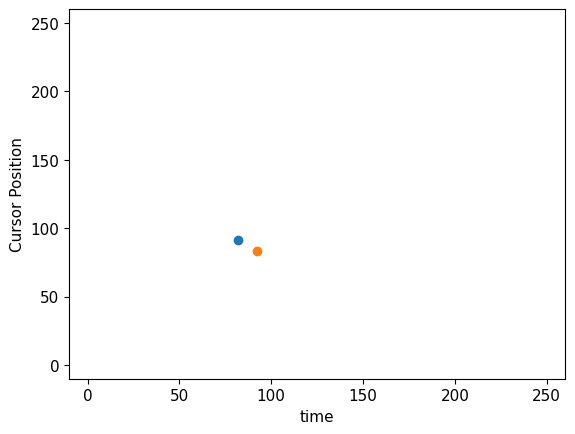

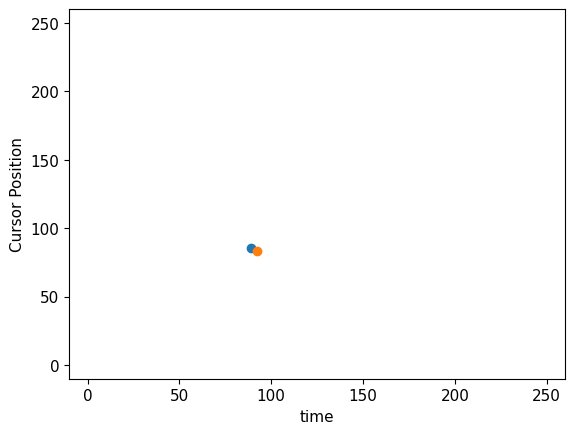

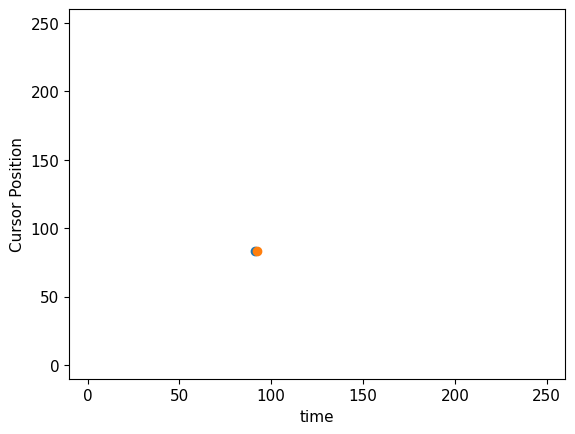

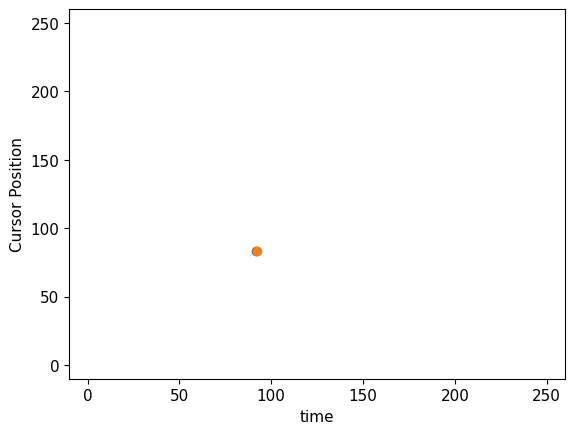

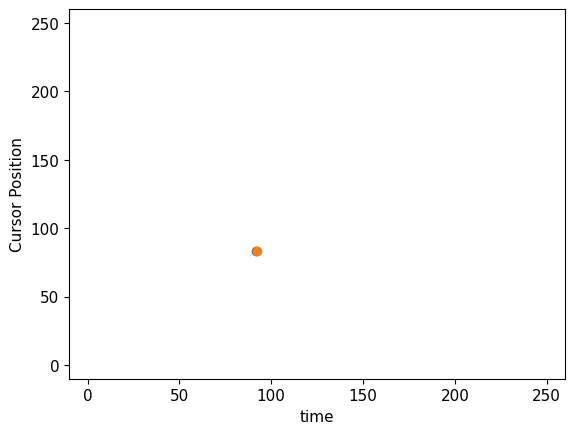

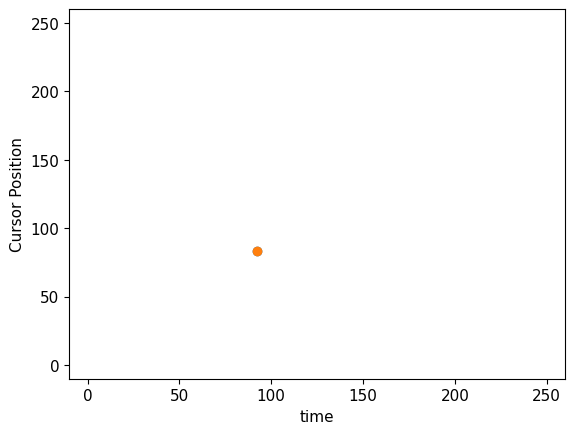

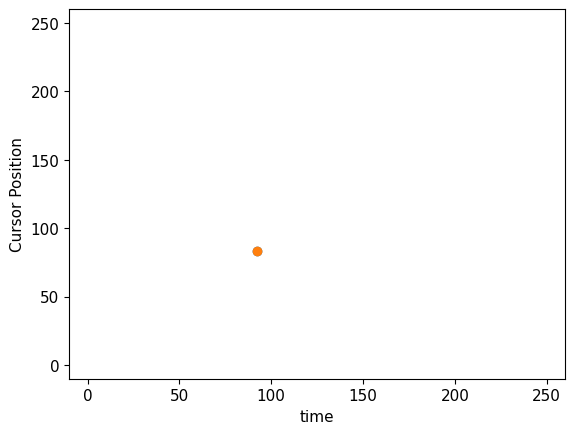

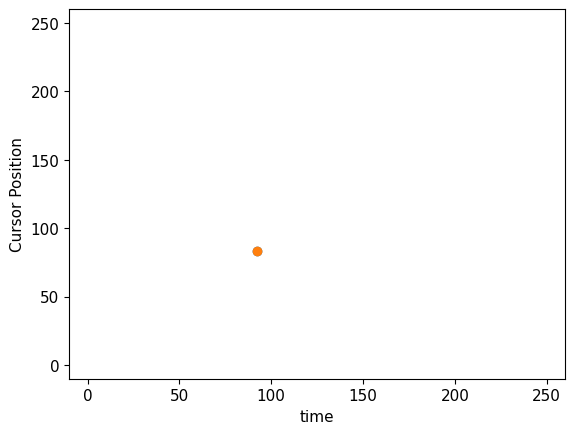

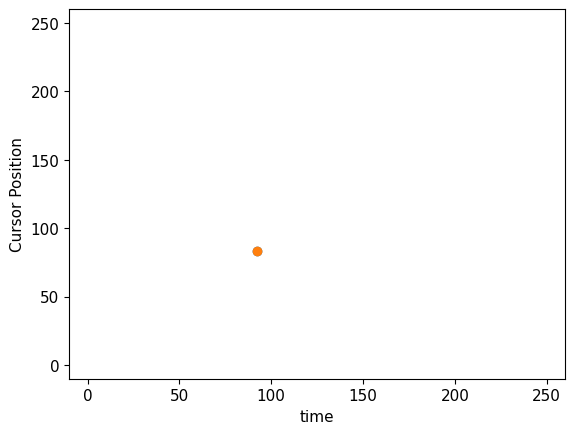

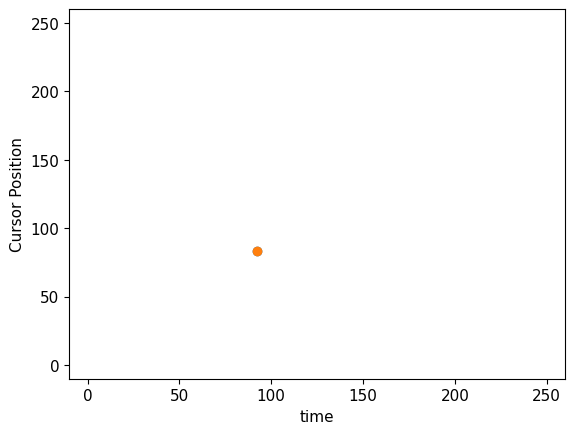

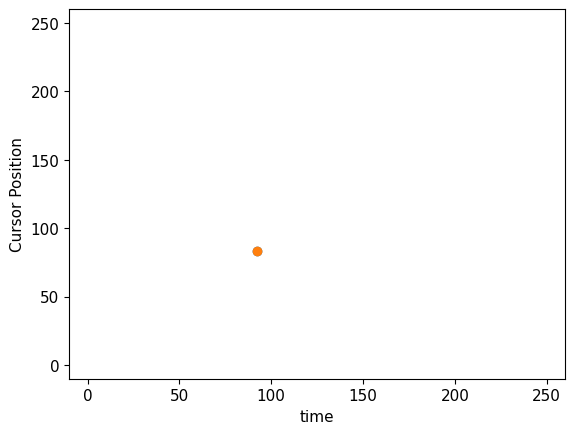

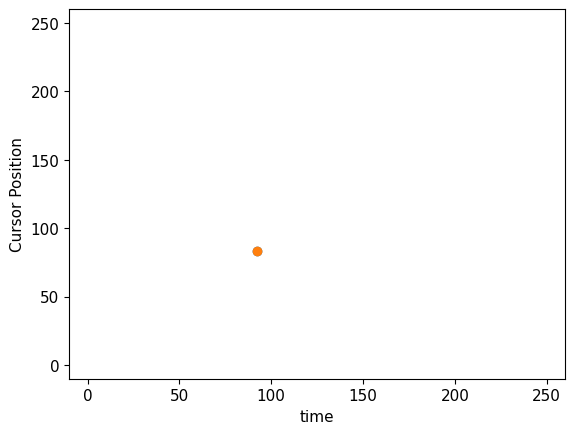

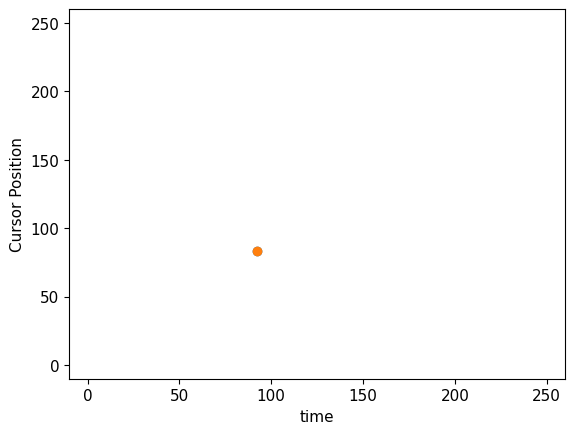

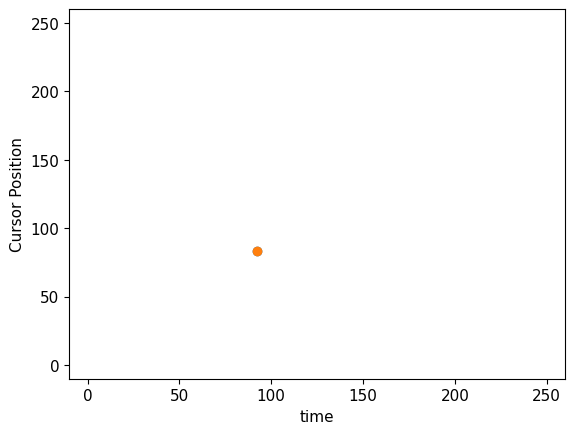

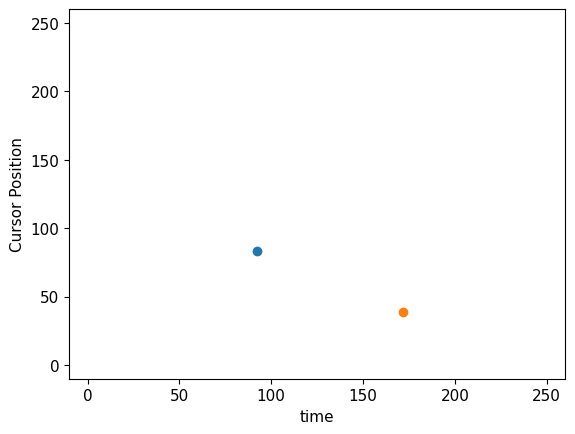

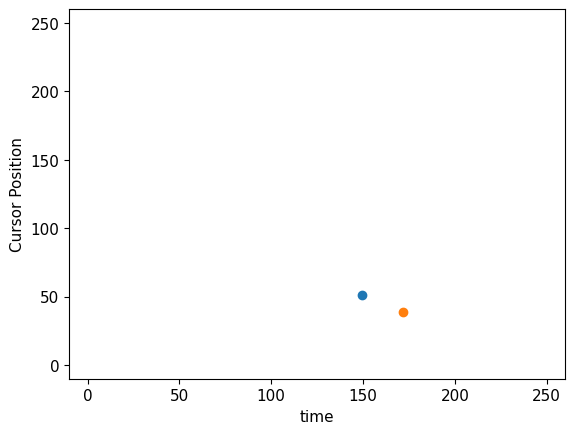

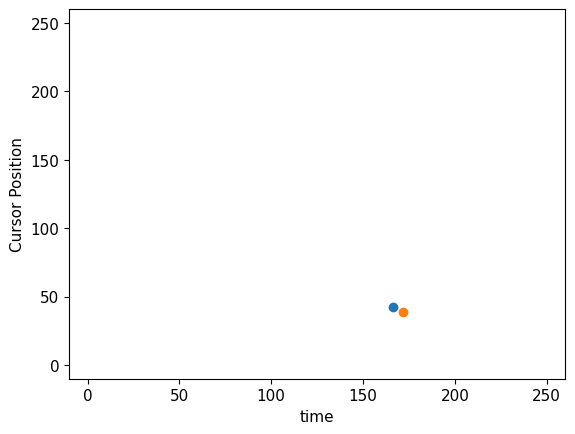

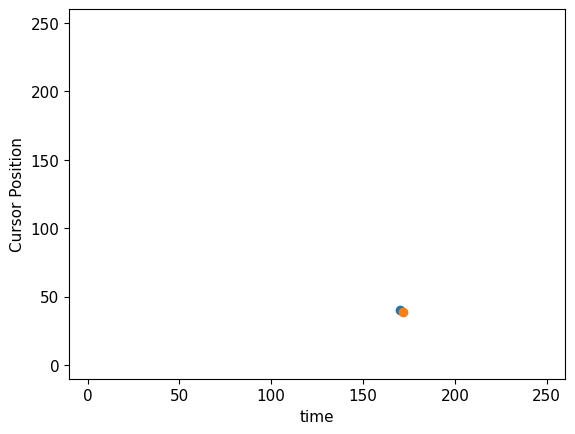

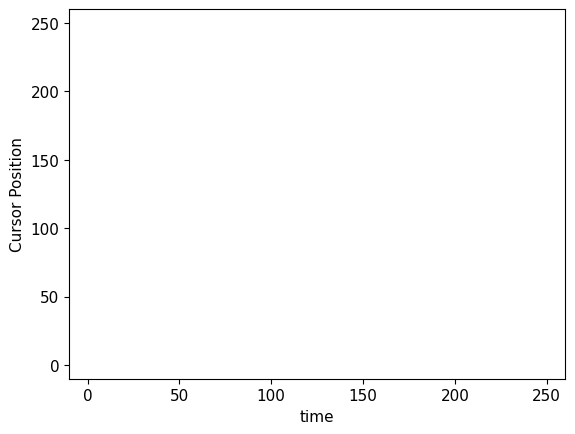

In [18]:
%matplotlib inline

from IPython import display
import random, time 
import matplotlib.pyplot as plt
from simple_pid import PID


class GameCursor:
    """
    Simple simulation of a cursor on screen
    """

    def __init__(self):
        self.position = [0, 0]
        
    def update(self, xMouseSpeed, yMouseSpeed, dt):
        if abs(xMouseSpeed + yMouseSpeed) > 0:
            self.position[0] += 1 * xMouseSpeed * dt
            self.position[1] += 1 * yMouseSpeed * dt
        return self.position



cursor = GameCursor()
position = cursor.position
Kp = 10
Ki = 0.01
Kd = 0.01
max = 250

xpid = PID(Kp, Ki, Kd, setpoint=0)
ypid = PID(Kp, Ki, Kd, setpoint=0)
xpid.output_limits = (-1000, 1000)
ypid.output_limits = (-1000, 1000)

start_time = time.time()
last_time = start_time
   
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

while time.time() - start_time <= 5:
    current_time = time.time()
    dt = current_time - last_time

    xMouseSpeed = xpid(position[0])
    yMouseSpeed = ypid(position[1])
    position = cursor.update(xMouseSpeed, yMouseSpeed, dt)

    if (int(current_time) - int(last_time) >= 1):

        xpid.setpoint = random.randint(0, max)
        ypid.setpoint = random.randint(0, max)

    last_time = current_time
    
    plt.scatter(position[0], position[1], label='measured')
    plt.scatter(xpid.setpoint, ypid.setpoint, label='target')
    display.display(plt.gcf())
    plt.figure().clear()
    plt.xlabel('time')
    plt.ylabel('Cursor Position')
    plt.xlim([-10, max+10])
    plt.ylim([-10, max+10])
    display.clear_output(wait=True)

## Bringing it all together

In [19]:
# import the relevant libraries
import numpy as np
import cv2
from mss import mss
from PIL import Image

import torch

import ctypes
import time
import win32con

#User parameters
show = True # boolean if the user wants to see the model output

LOAD_MODEL_FILE = "Halo640v2.pt" # the saved model file name
auto_screen = True # boolean should the program find the screen size automatically
centering = .7 #centering is the decimal percentage of the screen to account for, from the center, from 0 to 1
threshold = .2 # threshold is the lowest confidence bound to be allowed to be considered a detection

targets = [0]
animals = [0, 15, 16, 17, 18, 19, 20, 21, 22, 23]

#set up PID for mouse control
Kp = 10
Ki = 0.01
Kd = 0.01
max = 250

xpid = PID(Kp, Ki, Kd, setpoint=0)
ypid = PID(Kp, Ki, Kd, setpoint=0)
xpid.output_limits = (-100, 100)
ypid.output_limits = (-100, 100)


In [20]:
# if the user wants to
if auto_screen:
    w, h = ctypes.windll.user32.GetSystemMetrics(0), ctypes.windll.user32.GetSystemMetrics(1)
else:
    w, h = 1280,807 # if the user wants to define the screen size, do so here

# find the center point of the screen
x_center = ctypes.windll.user32.GetSystemMetrics(0)/2
y_center = ctypes.windll.user32.GetSystemMetrics(1)/2

# because we want to be able to take screen captures that do not use the entire screen, we need to define the top, bottom, left, and right bounds of the box in pixels
top = int(y_center - (y_center * centering))
left = int(x_center - (x_center * centering))
bottom = int(y_center + (y_center * centering))
right = int(x_center + (x_center * centering))

width = int(w * centering)
height = int(h * centering)

# we save these as a dictionary to be used with
monitor = {'top': top, 'left': left, 'width': width, 'height': height}
sct = mss() #instantiate the screenshot application

x_center = width / 2
y_center = height / 2

In [21]:
# Begin the loop of screen inference
while True:

    startFrameTime = time.time() # begin a timer to calculate framerate

    img = np.array(sct.grab(monitor)) #capture the image

    predictions = model(img).pred # perform inference of the image.
    framerate = 1/(time.time() - startFrameTime) # stop the timer and calculate the framerate

    cv2.putText(img, str(framerate), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA) #add framerate to the cv2 image

    # add the aim point to the image
    cv2.circle(img,
        (int(x_center), int(y_center)),
        radius=5,
        color=(0, 255, 0),
        thickness=5
    )


    if len(predictions) > 0: # if there were any predicted targets
        closest = 99999 # set an arbitrarily large value for distance to the center
        for box in predictions[0]: # loop through all predicted targets
            if box[4] > threshold and box[5] in targets: # if the prediction is above the user set confidence threshold
                x = (box[2] + box[0]) / 2 # find the x pixel value for the target
                y = ((box[3] + box[1]) / 2) - ((box[3] - box[1]) / 3) # find the y pixel value for the target (scale up by 1/3 to aim for headshots)
                class_num = int(box[5]) # find the class value for the target

                # add the target to the image
                cv2.circle(img,
                    (int(x), int(y)),
                    radius=10,
                    color=(255, 0, 0),
                    thickness=5
                )
                cv2.rectangle(img,
                            (int(box[0]), int(box[1])),
                            (int(box[2]), int(box[3])),
                            color=(0, 255, 0),
                            thickness=2,
                            )
                # cv2.putText(img,
                #             org=(int(box[0]), int(box[1])), 
                #             text=str(model.names[class_num]), 
                #             fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                #             fontScale=1, 
                #             color=(255,0,0),
                #             thickness=2
                #             )

                # Calculate the distance to the target
                dx_ = int(x.item()-x_center)
                dy_ = int(y.item()-y_center)
                dist = (dx_**2 + dy_**2)**(.5)

                # if this target is closer than the previous closest target, save its infromation as the closest target
                if dist < closest:
                    closest = dist
                    # negate the values to move the right direction
                    dx = -dx_ 
                    dy = -dy_

                    cv2.putText(img,
                                org=(int(box[0]), int(box[1])), 
                                text=str(dx) + " " + str(dy), 
                                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                                fontScale=1, 
                                color=(255,0,0),
                                thickness=2
                                )  

        # When the user requests, control the mouse
        if keyboard.is_pressed('f1') and closest < 99999:
            #check if continuation of autoAim from last frame

            if not autoAim:
                startTime = time.time() #get the start time
                autoAim=True
                #initiate the PID
                xpid = PID(Kp, Ki, Kd, setpoint=0)
                ypid = PID(Kp, Ki, Kd, setpoint=0)
            else:
                lastTime = time.time()
                dt = lastTime - startTime

                win32api.mouse_event(win32con.MOUSEEVENTF_MOVE, # use the windows api to move the mouse
                                        int(xpid(dx)*dt), # this is the x increment to move
                                        int(ypid(dy)*dt), # this is the y incrememnt to move
                                        )
                if dist < 50:
                    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTDOWN,0,0)
                    time.sleep(0.001)
                    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTUP,0,0)
                startTime = lastTime #reset my timer
        else:
            autoAim=False
        
    if show:
        cv2.imshow('Model View', img) # if the user wants to see the model view, rearrange the channels and show the image

        if cv2.waitKey(1) & 0xFF == ord('q'): # The wait insures the image is shown, and the other portion of the command allows the user to stop the program by pressing 'q'
            cv2.destroyAllWindows() # destroy the image window
            break # step out of the loop